In [68]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import numpy as np
import random

pd.options.display.max_colwidth = 250

In [69]:
# read original csv file and remove newline characters
df = pd.read_csv('./datasets/syllabi-dataset.csv')
df['Description'] = df['Description'].str.replace('\n', ' ')
# save to csv
df.to_csv('./datasets/lo-dataset.csv', index=False)

In [70]:
df = pd.read_csv('./datasets/lo-dataset.csv')

# Drop duplicates
df = df.drop_duplicates()
#fill NaN values with empty string
df = df.fillna('')
# df.head()

In [71]:
# general data cleaning
# lowercase
df['Description'] = df['Description'].apply(lambda x: x.lower())
# remove punctuation and numbers
df['Description'] = df['Description'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))
#df.head(10)

In [72]:
#nltk.download('stopwords')
#nltk.download('punkt')
learning_outcome_stopwords = stopwords.words('english')
# add custom stopwords for course descriptions
learning_outcome_stopwords.extend(['use', 'using', 'students', 'able', 'skills', 'develop', 'identify', 'understand', 'demonstrate', 'cms', 'en', 'levelappropriate', \
                                   'ontario'])
print(learning_outcome_stopwords)
# df.head(10)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [73]:

def remove_stopwords(description):
    # Tokenize the description
    tokens = word_tokenize(description)
    # Remove stopwords 
    filtered_tokens = [word for word in tokens if word not in learning_outcome_stopwords]
    # Rejoin the filtered tokens into a string
    filtered_description = ' '.join(filtered_tokens)
    return filtered_description

# Apply the cleaning function to each description
df['Description'] = df['Description'].apply(remove_stopwords)

# remove rows with empty descriptions now that we have removed stopwords
df = df[df['Description'] != '']

# save cleaned data
df.to_csv('./datasets/cleaned-lo-dataset.csv', index=False)

In [77]:
# Latent Dirichlet Allocation (LDA) Model using scikit-learn
data = pd.read_csv('./datasets/cleaned-lo-dataset.csv')
# Create a CountVectorizer for LDA
vectorizer = CountVectorizer(stop_words=learning_outcome_stopwords, max_df=0.95, min_df=2)
count_data = vectorizer.fit_transform(data['Description'])
print(vectorizer.get_feature_names_out())

n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=1000)
lda.fit(count_data)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx+1))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)


['abilities' 'ability' 'abnormal' ... 'yoga' 'young' 'youth']
Topic 1:
spanish explain describe law simple including legal understanding system topics
Topic 2:
writing appropriate research apply information ideas analyze evaluate academic critical
Topic 3:
health care nursing practice describe healthcare patient apply management discuss
Topic 4:
student knowledge analyze music social historical solve german explain cultural
Topic 5:
art development network literary learn appropriate historical support business system
Topic 6:
accounting describe explain financial analyze marketing business apply political various
Topic 7:
describe explain data processes basic structure chemical scientific different system
Topic 8:
models yoga learning language german tools building create techniques social
Topic 9:
ability social communication knowledge research include written critical understanding analysis
Topic 10:
design data apply problems information principles appropriate solve communicate anal

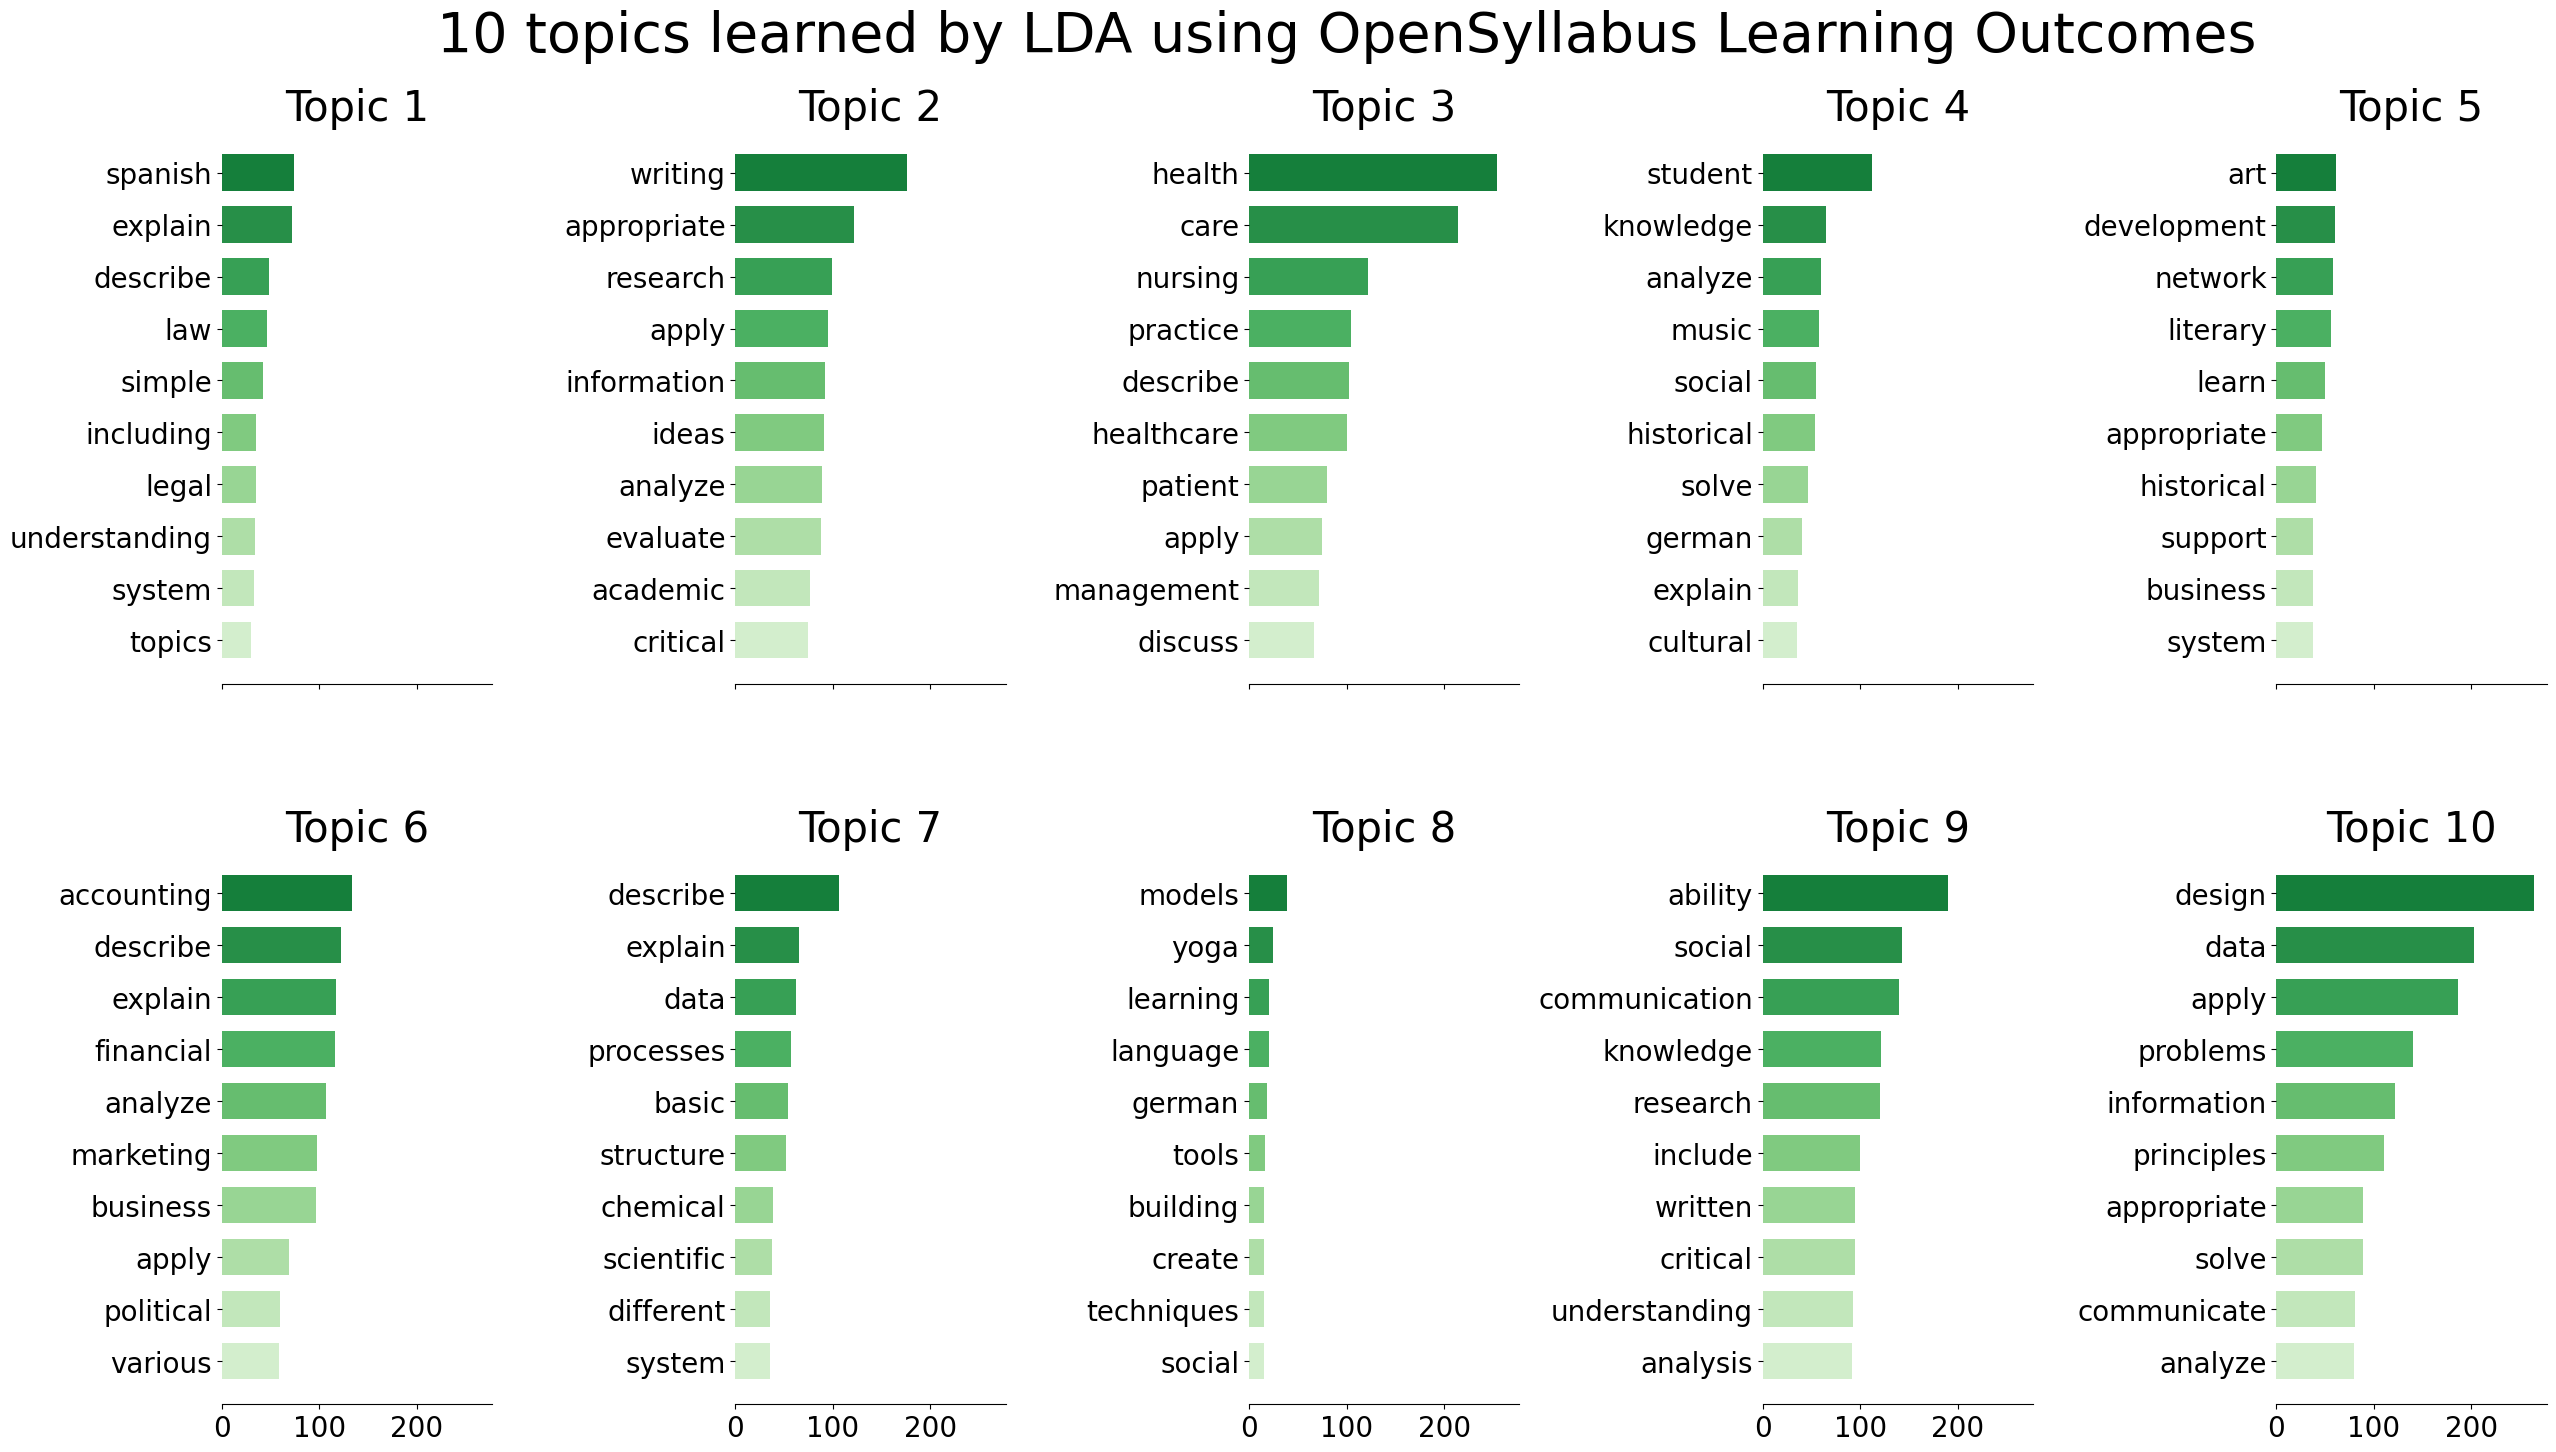

In [78]:
colormaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    color = random.choice(colormaps)
    colors = plt.get_cmap(color)(np.linspace(0.2, 0.8, n_top_words))

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color=colors)  # Specify the colors for each bar
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(lda, vectorizer.get_feature_names_out(), no_top_words, f'{no_top_words} topics learned by LDA using OpenSyllabus Learning Outcomes')

In [76]:
# wordcloud
# from wordcloud import WordCloud
# long_string = ' '.join(df['Description'])
# wordcloud = WordCloud(width=2000, height=1400, background_color='white').generate(long_string)
# wordcloud.to_file('./wordclouds/learning_outcomes_wordcloud.png')